# „Hiszem, ha látom – Az űrkutatás médiaképe a hírcímek tükrében”

*Adat vs érzés: Nem elméleti alapon mondjuk meg, milyen a hangulat az űrkutatás körül, hanem valódi hírcímek elemzéséből.*

*Ebben a projektben az űrkutatás médiaképét vizsgáltam négy altémában (siker/kudarc, technológia/indítások, Hold/Mars, politika/finanszírozás), és azt mutatom meg, hogyan különbözik az országok hangulata az egyes területeken – vizualizációval és példacímekkel alátámasztva.*

### Módszertan

Az elemzés több lépésből épül fel, amelyeket minden altémánál azonos logika szerint ismételtem meg:

Első lépésben országonként gyűjtöttem össze a hírcímeket RSS-csatornákból, majd kulcsszavak segítségével kiszűrtem az adott altémához tartozó cikkeket. Az angol nyelvű hírek érzelemelemzésére a VADER modellt használtam, míg a nem angol nyelvű esetekben egy többnyelvű Transformer-modell adott megbízható eredményt. Az így kapott adatokból országonként számítottam mediánt, átlagot, valamint pozitív és negatív arányokat, amelyek alapján különböző interaktív térképeket és ábrákat készítettem. Az elemzés végén az angol és nem angol adatok összefűzésével egy teljesebb, globális képet kaptunk az adott altéma médiamegjelenéseiről.

___1. ALTÉMA: SIKER VS KUDARC___

*0) Importok és beállítások*


Betöltjük a `utils.py` segédfüggvényeit (letöltés, érzelemelemzés, aggregálás, térkép), 
beállítjuk a `TOPIC_NAME`-t és a cache módot (`USE_CACHE`). A VADER lexikont egyszer letöltjük.

In [1]:
# --- 0) IMPORTOK ÉS BEÁLLÍTÁSOK ---

from utils import (
    countries, non_english_countries, iso2_to_iso3,
    get_countries_df, add_iso3,
    fetch_gnews_for_countries,
    score_sentiment_vader, load_xlmr_model, predict_sentiment_batch_xlmr,
    make_country_aggregates, plot_four_maps_for_topic, top_examples_all
)

# VADER lexikon (EN-hez)
import nltk
nltk.download('vader_lexicon', quiet=True)

TOPIC_NAME = "success_failure"   # vagy: tech_launch / moon_mars / politics_finance
USE_CACHE  = True                # ha van korábbi CSV, onnan olvas


*1) Adatgyűjtés - keresőkifejezések*


A `topic_query` kulcsszólista az altéma tartalmát fedi le. Ezt adjuk át a Google News RSS-nek.  
Opcionálisan kizárhatunk zajos szavakat is (pl. `-rumor -speculation`), ha túl sok a zavaró találat.

In [2]:
# --- 1) KERESŐKIFEJEZÉSEK: base (ld. űrkutatás) + theme: Siker/Kudarc (ld. altéma) ---

TOPIC_NAME = "success_failure"

base_terms = [
    '"space exploration"', '"space mission"', '"space flight"',
    'NASA','ESA','SpaceX','Blue Origin','ISRO','Roscosmos',
    'satellite','telescope','rocket','lunar','moon','mars','rover'
]
theme_terms = [
    'success','successful','milestone',   # pozitív
    'failure','scrubbed','delayed','exploded'  # negatív/kudarc
]
topic_base = " OR ".join(base_terms)
topic_theme = " OR ".join(theme_terms)
topic_query = f"({topic_base}) OR ({topic_theme})"

*2) Adatgyűjtés - Angol hírek lekérése + VADER*
- országonként lekérjük a hírcímeket (`fetch_gnews_for_countries`),
- nyersen elmentjük CSV-be (backup),
- VADER-rel pontozzuk a címeket (−1..+1),
- kategorizálunk (positive / neutral / negative),
- hozzáadjuk az ISO3 kódot a térképekhez,
- feldolgozott CSV-be mentjük (Power BI-hoz is jó).
Ha `USE_CACHE=True` és létezik a feldolgozott CSV, akkor csak betöltünk.

In [3]:
# --- 2) Angol hírek lekérése - VADER ---

import os, pandas as pd
en_raw  = f"data/raw/{TOPIC_NAME}_en_raw.csv"
en_proc = f"data/processed/{TOPIC_NAME}_en.csv"
os.makedirs("data/raw", exist_ok=True); os.makedirs("data/processed", exist_ok=True)

if USE_CACHE and os.path.exists(en_proc):
    news_en = pd.read_csv(en_proc)
else:
    news_en = fetch_gnews_for_countries(topic_query, countries, limit=120, source_lang="EN")
    news_en.to_csv(en_raw, index=False)  # nyers

    news_en["sentiment"] = news_en["title"].apply(score_sentiment_vader)
    news_en["sentiment_label"] = news_en["sentiment"].apply(
        lambda x: "positive" if x>=0.2 else ("negative" if x<=-0.2 else "neutral")
    )
    news_en = add_iso3(news_en, "iso2")
    news_en.to_csv(en_proc, index=False)  # feldolgozott

*3) Adatgyűjtés - nem angol hírek + XLM-R*
- országonként letöltjük a cikkeket, nyersen mentjük,
- többnyelvű XLM-R modellel címkézzük (negative/neutral/positive),
- −1/0/+1 értékre mappoljuk,
- ISO3 kódot adunk, feldolgozott CSV-be mentjük.
Cache esetén csak beolvasunk.

In [4]:
# --- 3) Nem angol nyelvű hírek - XLM-R ---


non_raw  = f"data/raw/{TOPIC_NAME}_non_en_raw.csv"
non_proc = f"data/processed/{TOPIC_NAME}_non_en.csv"

if USE_CACHE and os.path.exists(non_proc):
    news_non = pd.read_csv(non_proc)
else:
    news_non = fetch_gnews_for_countries(topic_query, non_english_countries, limit=120, source_lang="NON_EN")
    news_non.to_csv(non_raw, index=False)

    tok, mdl, device = load_xlmr_model()
    news_non["sentiment_label"] = predict_sentiment_batch_xlmr(news_non["title"].tolist(), tok, mdl, device)
    news_non["sentiment"] = news_non["sentiment_label"].map({"negative":-1.0,"neutral":0.0,"positive":1.0})
    news_non = add_iso3(news_non, "iso2")
    news_non.to_csv(non_proc, index=False)


*4) Összefűzés + (opcionális) EN pont átskálázás*


Összerakjuk az EN és NON-EN adatokat egy `all_news` táblába.  
Ha országonkénti mediánt/átlagot -1/0/+1 skálán akarunk, az EN pontszámot is ilyen skálára 
mappoljuk (küszöb: ±0.2). Ez stabilabb összevetést ad.

In [5]:
# --- 4) ÖSSZEFŰZÉS ---

all_news = pd.concat([news_en, news_non], ignore_index=True)

# ha kombinált mediánt/átlagot szeretnénk -1/0/+1-en: EN átskálázása
def to_combo(row):
    if row["source_lang"] == "EN":
        x = row["sentiment"]
        return 1.0 if x>=0.2 else (-1.0 if x<=-0.2 else 0.0)
    return row["sentiment"]

all_news["sentiment"] = all_news.apply(to_combo, axis=1)

*5) Kibővített vizualizáció (4 térkép) + CSV-k*


Négy interaktív térképet: országonkénti medián, átlag, pozitív arány, negatív arány.  
Az eredményeket CSV-be is mentjük, hogy Power BI-ban felhasználhassuk.

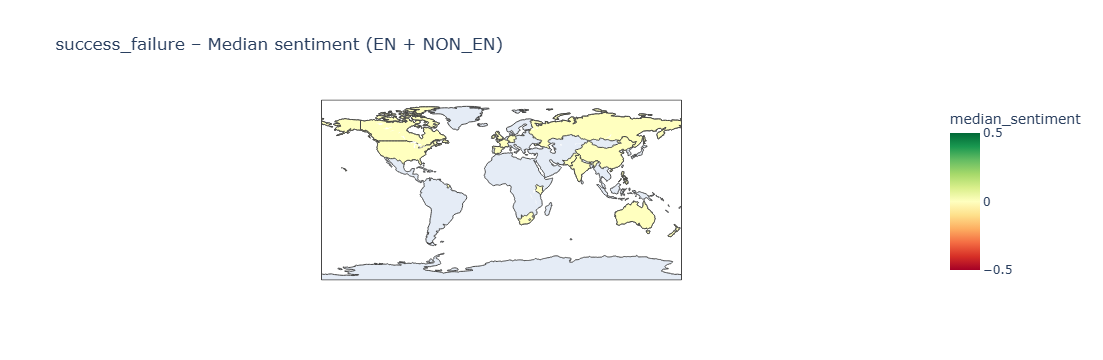

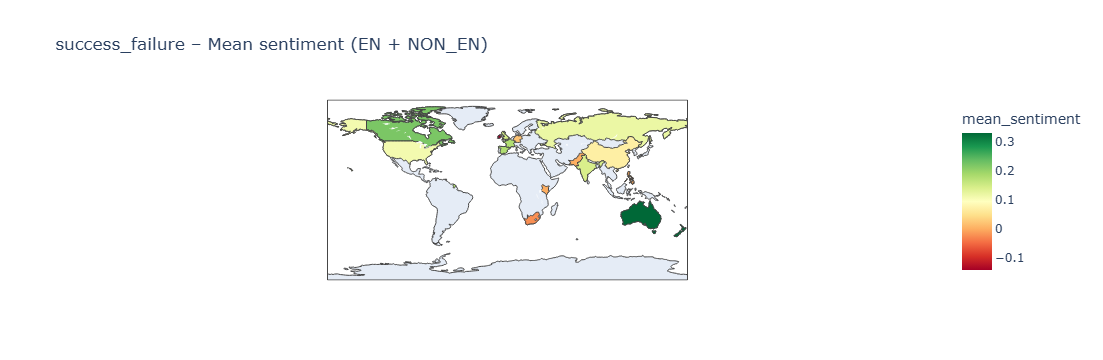

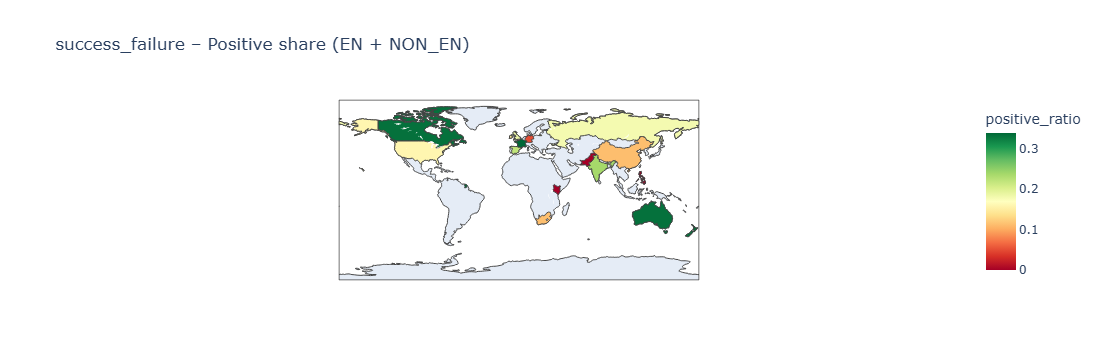

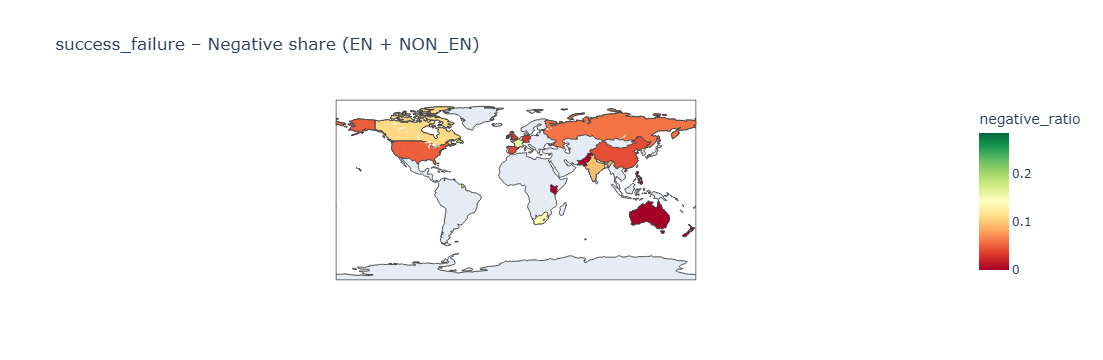

In [6]:
# --- 5) TÉRKÉPEK ---

plot_four_maps_for_topic(all_news, topic_name=TOPIC_NAME, use_iso3=True)

*6) „Hiszem, ha látom” – TOP példacímek*


Nem csak számok: 10–10 pozitív/negatív cím mutatja a tipikus narratívát.

In [7]:
# --- 6) TOPLISTA ---

top_pos = top_examples_all(all_news, "positive", 10, per_country=False)
top_neg = top_examples_all(all_news, "negative", 10, per_country=False)
display(top_pos); display(top_neg)

,country,source_lang,title,sentiment,sentiment_label,source,link
0,United States,EN,NASA Seeks Proposals for 2026 Human Exploratio...,1.0,positive,NASA (.gov),https://news.google.com/rss/articles/CBMiuAFBV...
1,United States,EN,What would Mars look like in daylight? 'Enhanc...,1.0,positive,USA Today,https://news.google.com/rss/articles/CBMiqwFBV...
2,United States,EN,NASA’s Perseverance Rover Captures Mars Vista ...,1.0,positive,NASA Jet Propulsion Laboratory (JPL) (.gov),https://news.google.com/rss/articles/CBMilgFBV...
3,United States,EN,An Area Known as ‘Falbreen’ on Mars Saw Some B...,1.0,positive,thisiscolossal.com,https://news.google.com/rss/articles/CBMibEFVX...
4,United States,EN,NASA seeks student entries for Human Explorati...,1.0,positive,upi.com,https://news.google.com/rss/articles/CBMikAFBV...
5,United States,EN,Clear skies on Mars as NASA rover captures one...,1.0,positive,BBC Sky at Night Magazine,https://news.google.com/rss/articles/CBMifEFVX...
6,United States,EN,NASA rover spots rock shaped like medieval hel...,1.0,positive,New York Post,https://news.google.com/rss/articles/CBMinAFBV...
7,United States,EN,Stunning New NASA Perseverance Rover Images Sh...,1.0,positive,SciTechDaily,https://news.google.com/rss/articles/CBMipwFBV...
8,United States,EN,Christine Baranski Blasts Blue Origin Flight C...,1.0,positive,People.com,https://news.google.com/rss/articles/CBMirwFBV...
9,United States,EN,Exclusive | NASA + ISRO + One Vision: Project ...,1.0,positive,ETV Bharat,https://news.google.com/rss/articles/CBMi0wFBV...


,country,source_lang,title,sentiment,sentiment_label,source,link
0,United States,EN,CANCELLED: Muncie Three Trails Music Series – ...,-1.0,negative,Ball State University,https://news.google.com/rss/articles/CBMinAFBV...
1,United States,EN,California commission rejects proposal to incr...,-1.0,negative,The Hill,https://news.google.com/rss/articles/CBMikAFBV...
2,United States,EN,Hijacked Satellites And Orbiting Space Weapons...,-1.0,negative,ETV Bharat,https://news.google.com/rss/articles/CBMi5gFBV...
3,United States,EN,Critics shouldn’t block NASA’s nuclear path to...,-1.0,negative,The Hill,https://news.google.com/rss/articles/CBMihgFBV...
4,United States,EN,NASA Orbiter Spots Curiosity Rover Making Trac...,-1.0,negative,NASA Jet Propulsion Laboratory (JPL) (.gov),https://news.google.com/rss/articles/CBMiogFBV...
5,United Kingdom,EN,The Blue Origin flight showcased the utter def...,-1.0,negative,The Guardian,https://news.google.com/rss/articles/CBMilAFBV...
6,Canada,EN,NASA Unveils Possible Building Blocks of Life ...,-1.0,negative,SciTechDaily,https://news.google.com/rss/articles/CBMimAFBV...
7,India,EN,"SpaceX rocket being tested in Texas explodes, ...",-1.0,negative,The Hindu,https://news.google.com/rss/articles/CBMizgFBV...
8,India,EN,"Weather, Rocket Issues May Further Delay India...",-1.0,negative,NDTV,https://news.google.com/rss/articles/CBMi6AFBV...
9,Ireland,EN,Watch: SpaceX rocket spins out of control in t...,-1.0,negative,BBC,https://news.google.com/rss/articles/CBMiV0FVX...
